## В результате проверки (на отложенной тренировочной выборке) различных параметров в ходе экспериментов было выяснено, что лучшие параметры таковы:
* model_type = SGD
* step_alpha = 1
* step_beta = 0.001
* min_df = 2.5e-5
* preprocesser_type = BOW
    

In [1]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [3]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

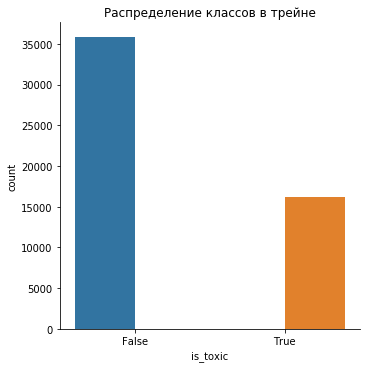

In [4]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [5]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

target_test = test_data['is_toxic'].map({True : 1, False : -1})
test_data.drop(columns='is_toxic', inplace=True)

In [6]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [7]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [8]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

In [9]:
import nltk
nltk.download('wordnet')
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])

CPU times: user 11.5 s, sys: 88 ms, total: 11.6 s
Wall time: 11.6 s


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=False)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [13]:
import optimization

In [14]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [15]:
train_data_processed_3_with_bias

<52061x32272 sparse matrix of type '<class 'numpy.float64'>'
	with 2021651 stored elements in Compressed Sparse Row format>

In [16]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 2min 25s, sys: 3.82 s, total: 2min 29s
Wall time: 18.7 s


In [18]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 43.5 ms, sys: 46 µs, total: 43.5 ms
Wall time: 42.7 ms


0.8853743470690656

In [ ]:
0.8853743470690656

In [39]:
probs = sgd_classifier.predict_proba(test_data_processed_3_with_bias)

In [55]:
errors_mask = np.where(np.argmax(probs, axis=1) == 0, -1, 1) != target_test.values

In [60]:
test_data_processed_1[errors_mask], 

(1                          dear god this site is horrible 
 17              balance     this page has one sentence ...
 27       i will burn you to hell if you revoke my talk ...
 50       avg  plenty of greeks love the king  stop acti...
 56        this is just bizarre  ani medjool s abuse of ...
                                ...                        
 63515    as i am a teenager  i feel the need to say  sh...
 63636            yeah  sure  you say you welcome discus...
 63781             shut up and learn to sign your comments 
 63782                  baylor kids like to kill themselves
 63962            iran      that s right  iran  it was o...
 Name: comment_text, Length: 2370, dtype: object,
 array([[0.45312804, 0.54687196],
        [0.        , 1.        ],
        [0.08383635, 0.91616365],
        ...,
        [0.67678816, 0.32321184],
        [0.62992949, 0.37007051],
        [0.80037573, 0.19962427]]))

In [76]:
errors_with_high_prob_mask = np.where(probs[errors_mask].max(axis=1) > 0.85)[0]

In [124]:
[(i, target)
  for i, target in zip(test_data_processed_1[errors_with_high_prob_mask], target_test[errors_with_high_prob_mask]) 
         if 'not' in i]

[(' redslash  cut it short  if you have sources stating the rok is sovereign post them  otherwise please aknowledge wp is not the place to make or ',
  -1),
 ('               jews are not a race because you can only get it from your mother  your own mention of ethiopian jews not testing             as jews proves it is not  as well as the fact that we accept converts',
  -1),
 ('      not sure whether this is notable enough to be mentioned in the article  but you re right   versions later than 6  2001  can open files created by all previous versions  but save files only in its own format  with a suffix of    msx    where x is the version number  7  8  9  10  11  12      this is intentional  of course  besides  all versions but 7 save files in a compressed format   共产主义万岁   ',
  -1),
 ('    i m not convinced that he was blind  where is this documented  it s possible that he was just what we d call   legally blind   ie didn t have great vision  and that the name   blind blake   is an exa

In [114]:
indx = 2354
test_data_processed_1[errors_with_high_prob_mask][indx], target_test[errors_with_high_prob_mask][indx]

('   i didn t screw up  i lapsed  when you revert  you should examine what the previous editor did  as several reverters are doing  reverting again me at amin al husseini so blindly they do not notice they are removing intermediate edits involving correction of dates and spellings  it means that this is personal  or ideological  and not motivated by intelligent assessments of the merits ',
 -1)

## Доп. задание  №1

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
%%time
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = TfidfVectorizer(min_df=2.5e-5, lowercase=False, ngram_range=(1, 5))


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

CPU times: user 43.2 s, sys: 700 ms, total: 43.9 s
Wall time: 42.2 s


In [61]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [62]:
train_data_processed_3_with_bias

<52061x724326 sparse matrix of type '<class 'numpy.float64'>'
	with 6348427 stored elements in Compressed Sparse Row format>

In [63]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 6min 22s, sys: 6.58 s, total: 6min 29s
Wall time: 48.7 s


In [64]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 339 ms, sys: 15.8 ms, total: 354 ms
Wall time: 44.3 ms


0.8766686012768428

### Попробуем убрать приведение к одному регистру, так как капс может показывать некоторую агрессию

In [125]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [126]:
def text_process(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [127]:
train_data_processed_1 = text_process(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process(test_data_processed_1['comment_text'])

In [128]:
import nltk
nltk.download('wordnet')
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [129]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])

CPU times: user 10.5 s, sys: 48 ms, total: 10.6 s
Wall time: 10.6 s


In [130]:
from sklearn.feature_extraction.text import CountVectorizer

In [138]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=False)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

## Проверим на отложенной выборке:

In [85]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [86]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 9min 29s, sys: 10.8 s, total: 9min 40s
Wall time: 1min 12s


In [88]:
history['accuracy'][-1]

0.8879569754785838

Точность уменьшилась :( Проверим на тесте:

In [89]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [90]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values)

CPU times: user 9min 30s, sys: 15.9 s, total: 9min 46s
Wall time: 1min 14s


In [91]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 352 ms, sys: 8.17 ms, total: 360 ms
Wall time: 44.9 ms


0.8766686012768428

 Тоже стала хуже :(

## Попробуем добавить новые признаки:

In [93]:
train_data

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
...,...
159494,"""\n\n our previous conversation \n\nyou fuckin..."
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR
159541,Your absurd edits \n\nYour absurd edits on gre...
159546,"""\n\nHey listen don't you ever!!!! Delete my e..."


In [127]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
# train_new_features = train_data.copy()


# train_new_features['count_sent']=train_data["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
# #Word count in each comment:
# train_new_features['count_word']=train_data["comment_text"].apply(lambda x: len(str(x).split()))
# #Unique word count
# train_new_features['count_unique_word']=train_data["comment_text"].apply(lambda x: len(set(str(x).split())))
# #Letter count
# train_new_features['count_letters']=train_data["comment_text"].apply(lambda x: len(str(x)))
# #punctuation count
# train_new_features["count_punctuations"] =train_data["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# #upper case words count
# train_new_features["count_words_upper"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# #title case words count
# train_new_features["count_words_title"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# #Number of stopwords
# train_new_features["count_stopwords"] = train_data["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords_set]))
# #Average length of the words
# train_new_features["mean_word_len"] = train_data["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [129]:
# train_new_features.drop(columns='comment_text', inplace=True)

In [163]:
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))
preprocesser = CountVectorizer(min_df=2.5e-5, lowercase=True)


train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
test_data_processed_3 = preprocesser.transform(test_data_processed_3)

bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [141]:
# train_data_processed_3_with_bias = scipy.sparse.hstack([train_data_processed_3_with_bias, train_new_features], 'csr')

In [142]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7
                                            )

In [133]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 4min 17s, sys: 5.86 s, total: 4min 23s
Wall time: 33.1 s


In [137]:
history['accuracy'][-1]

0.73180101158845

In [136]:
train_new_features

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,2,43,41,264,10,2,11,18,5.162791
1,1,17,17,112,12,1,3,2,5.588235
2,1,42,39,233,6,0,2,20,4.571429
3,5,113,82,622,21,5,7,56,4.486726
4,1,13,13,67,5,0,2,5,4.230769
...,...,...,...,...,...,...,...,...,...
159494,10,319,199,1677,58,8,20,138,4.241379
159514,1,6,6,33,0,6,1,3,4.666667
159541,3,58,46,346,6,0,5,30,4.948276
159546,3,103,75,534,30,6,8,54,4.184466


In [106]:
0.8683014277482554
0.8879569754785838

<52061x32276 sparse matrix of type '<class 'numpy.float64'>'
	with 2204291 stored elements in Compressed Sparse Row format>

Снова плохо :(

### Попробуем сделать так: будем сохранять лучшие веса, с которыми модель показала лучшую точность на отложенной выборке

In [145]:
sgd_classifier = optimization.SGDClassifier(batch_size=1024,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = True,
                                            l2_coef=5e-5,
                                            tolerance=5e-7,
                                            save_best_weights=True
                                            )

In [146]:
%%time
history = sgd_classifier.fit(train_data_processed_3_with_bias, target_train.values, trace=True)

CPU times: user 4min 13s, sys: 5.77 s, total: 4min 19s
Wall time: 32.6 s


In [147]:
max(history['accuracy'])

0.9108777770663935

In [148]:
sgd_classifier.w = history['best_weights']

In [149]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 44.9 ms, sys: 19 µs, total: 44.9 ms
Wall time: 43.8 ms


0.8804894563745406

### Попробуем использовать кросс-валидацию:

In [15]:
from sklearn.model_selection import KFold, StratifiedKFold

In [16]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True)
i = 1
preds = None
val_score_list = []
for trn_idx, valid_idx in kfold.split(train_data_processed_3_with_bias, target_train.values):
    sgd_classifier = optimization.SGDClassifier(batch_size=4096,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 1000,
                                            experiment = False,
                                            l2_coef=0.1,
                                            tolerance=5e-7,
                                            save_best_weights=False
                                            )
    history = sgd_classifier.fit(train_data_processed_3_with_bias[trn_idx],
                                 target_train.values[trn_idx], trace=True)
    val_score_list.append(np.sum(sgd_classifier.predict(train_data_processed_3_with_bias[valid_idx]) == target_train.values[valid_idx]) / valid_idx.shape[0])
    print(f'Fold: {i}, \
          accuracy: {val_score_list[-1]}')
    i += 1
    if preds is None:
        preds = sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits
    else:
        preds += sgd_classifier.predict_proba(test_data_processed_3_with_bias) / n_splits

print(f'Mean accuracy: {np.mean(val_score_list)}')    

Fold: 1,           accuracy: 0.6935561317583789
Fold: 2,           accuracy: 0.8006146753745678
Fold: 3,           accuracy: 0.7490395697272378
Fold: 4,           accuracy: 0.6976565501344603
Fold: 5,           accuracy: 0.698905109489051
Mean accuracy: 0.7279544072967391


In [17]:
np.sum(np.where(np.argmax(preds, axis=1) == 0, -1, 1) == target_test) / target_test.shape[0]

0.7205939253240472

In [41]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [42]:
def sgd_bayesian(step_alpha,
                 step_beta,
                 batch_size, l2_coef,  X_valid=None, y_valid=None):
    batch_size = int(batch_size)
    sgd_classifier = optimization.SGDClassifier(batch_size=batch_size,
                                            step_alpha=step_alpha,
                                            step_beta=step_beta,
                                            max_iter = 5000,
                                            experiment = True,
                                            l2_coef=l2_coef,
                                            tolerance=5e-7,
                                            save_best_weights=False
                                            )
    
    history = sgd_classifier.fit(train_data_processed_3_with_bias,
                                 target_train.values, trace=True)
    
    score = history['accuracy'][-1]
    return score

In [44]:
bounds_sgd = {
    'step_alpha': (0.0, 5.0),
    'step_beta': (0.0, 5),
    'l2_coef': (0, 1e-4),
    'batch_size': (128, 1500)
}

sgd_BO = BayesianOptimization(sgd_bayesian, bounds_sgd, random_state=13)

In [45]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sgd_BO.maximize(init_points=15, n_iter=25, acq='ucb')

|   iter    |  target   | batch_... |  l2_coef  | step_a... | step_beta |
-------------------------------------------------------------------------
|  1        |  0.311    |  1.195e+0 |  2.375e-0 |  4.121    |  4.812    |
|  2        |  0.3112   |  1.462e+0 |  4.534e-0 |  3.045    |  3.765    |
|  3        |  0.335    |  1.008e+0 |  7.22e-05 |  0.1752   |  1.141    |
|  4        |  0.3112   |  208.3    |  8.571e-0 |  1.864    |  3.239    |
|  5        |  0.311    |  479.6    |  3.476e-0 |  0.04706  |  1.471    |
|  6        |  0.311    |  1.43e+03 |  2.179e-0 |  1.597    |  4.548    |
|  7        |  0.3112   |  171.8    |  6.508e-0 |  3.149    |  4.306    |
|  8        |  0.8906   |  140.0    |  7.466e-0 |  4.064    | -0.08355  |
|  9        |  0.311    |  1.029e+0 |  5.093e-0 |  2.399    |  4.756    |
|  10       |  0.665    |  128.0    |  2.47e-05 |  3.561    |  1.285    |
|  11       |  0.7741   |  508.0    |  6.954e-0 |  4.593    |  0.8446   |
|  12       |  0.312    |  756.5    | 

|  67       |  0.311    |  346.9    |  0.0001   |  0.0      | -0.5      |
|  68       |  0.9106   |  852.0    |  0.0      |  5.0      | -0.5      |
|  69       |  0.3111   |  495.7    |  0.0001   |  5.0      |  5.0      |
|  70       |  0.7734   |  459.2    |  0.0001   |  5.0      | -0.5      |
|  71       |  0.9086   |  696.1    |  0.0      |  5.0      | -0.5      |
|  72       |  0.311    |  1.243e+0 |  0.0      |  0.0      |  5.0      |
|  73       |  0.311    |  990.5    |  0.0001   |  5.0      |  5.0      |
|  74       |  0.7938   |  1.489e+0 |  0.0001   |  5.0      | -0.5      |
|  75       |  0.7152   |  189.7    |  0.0001   |  5.0      | -0.5      |
|  76       |  0.311    |  457.9    |  0.0      |  0.0      |  5.0      |
|  77       |  0.311    |  737.9    |  0.0001   |  0.0      |  5.0      |
|  78       |  0.8627   |  720.0    |  0.0      |  5.0      | -0.5      |
|  79       |  0.3111   |  559.4    |  0.0001   |  5.0      |  5.0      |
|  80       |  0.9059   |  537.9    | 

In [46]:
sgd_BO.max

{'target': 0.9172802356104744,
 'params': {'batch_size': 521.1183095763585,
  'l2_coef': 0.0,
  'step_alpha': 5.0,
  'step_beta': -0.5}}

In [54]:
# {'target': 0.9158076701453358,
#  'params': {'batch_size': 1923.624192726998,
#   'l2_coef': 0.0,
#   'step_alpha': 16.744882359611136,
#   'step_beta': -1.0120822997912522}}
w_0 = np.zeros(train_data_processed_3_with_bias.shape[1])

In [74]:
sgd_classifier = optimization.SGDClassifier(batch_size=512,
                                            step_alpha=1,
                                            step_beta=0.001,
                                            max_iter = 10000,
                                            experiment = False,
                                            l2_coef=0,
                                            tolerance=5e-7,
                                            save_best_weights=False,
                                            )

In [75]:
# sgd_classifier = optimization.SGDClassifier(batch_size=256,
#                                             step_alpha=1,
#                                             step_beta=0.001,
#                                             max_iter = 10000,
#                                             experiment = False,
#                                             l2_coef=5e-5,
#                                             tolerance=5e-7
#                                             )

In [76]:
%%time
sgd_classifier.fit(train_data_processed_3_with_bias,
                   target_train.values, trace=True, w_0=w_0)

CPU times: user 57 s, sys: 1.08 s, total: 58.1 s
Wall time: 7.26 s


{'epoch_num': [0,
  1,
  2.003130942548162,
  3.0062618850963236,
  4.0093928276444855,
  5.012523770192693,
  6.0156547127409,
  7.018785655289107,
  8.021916597837313,
  9.02504754038552,
  10.028178482933727,
  11.031309425481934,
  12.034440368030141,
  13.037571310578349,
  14.040702253126556,
  15.043833195674763,
  16.04696413822296,
  17.050095080770987,
  18.053226023319013,
  19.05635696586704,
  20.059487908415065,
  21.06261885096309,
  22.065749793511117,
  23.068880736059143,
  24.07201167860717,
  25.075142621155194,
  26.07827356370322,
  27.081404506251246,
  28.084535448799272,
  29.087666391347298,
  30.090797333895324,
  31.09392827644335,
  32.097059218991376,
  33.1001901615394,
  34.10332110408743,
  35.106452046635454,
  36.10958298918348,
  37.112713931731506,
  38.11584487427953,
  39.11897581682756,
  40.12210675937558,
  41.12523770192361,
  42.128368644471635,
  43.13149958701966,
  44.13463052956769,
  45.13776147211571,
  46.14089241466374,
  47.144023357

In [77]:
%%time
sum(sgd_classifier.predict(test_data_processed_3_with_bias) == target_test.values) / target_test.shape[0]

CPU times: user 421 ms, sys: 4.2 ms, total: 425 ms
Wall time: 53.1 ms


0.8918069259044302

In [ ]:
0.8918069259044302